<div class="alert alert-success">
<h2> <b> Определение стоимости автомобилей </b> <font size="7" color=red> 🚗 </font></h2>
</div>

# Описание проекта

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

***Задача:***<br/>
Построить модель, которая может быстро определять рыночную стоимость автомобиля (задача регрессии).

Метрика качества - *RMSE* (не более 2500).

***Описание данных:***<br/>
Исторические данные о технических характеристиках, комплектации и цен автомобилей находяться в файле `/datasets/autos.csv`.

*Признаки*:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

*Целевой признак*:
* Price — цена (евро)

---

# Используемые библиотеки и инструменты

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     train_test_split,
                                     KFold)
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.metrics import (mean_squared_error,
                             make_scorer)
import warnings

In [ ]:
!pip install catboost -q
from catboost import CatBoostRegressor, Pool, cv

In [ ]:
warnings.filterwarnings('ignore')

# Анализ данных

In [ ]:
# Загрузка данных

try:
  original_data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
  original_data = pd.read_csv('autos.csv')

original_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480.0,NaN,1993.0,manual,0.0,golf,150000.0,0.0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500.0,small,2001.0,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21


In [ ]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25129 entries, 0 to 25128
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DateCrawled        25129 non-null  object 
 1   Price              25128 non-null  float64
 2   VehicleType        22413 non-null  object 
 3   RegistrationYear   25128 non-null  float64
 4   Gearbox            23745 non-null  object 
 5   Power              25128 non-null  float64
 6   Model              23772 non-null  object 
 7   Kilometer          25128 non-null  float64
 8   RegistrationMonth  25128 non-null  float64
 9   FuelType           22746 non-null  object 
 10  Brand              25128 non-null  object 
 11  Repaired           20069 non-null  object 
 12  DateCreated        25128 non-null  object 
 13  NumberOfPictures   25128 non-null  float64
 14  PostalCode         25128 non-null  float64
 15  LastSeen           25128 non-null  object 
dtypes: float64(7), object(

In [ ]:
# Анализ целевого признака

data_info = original_data.Price.describe()

print(f'Средняя цена: {round(data_info[1])}')
print(f'Средневадратичное отклонение: {round(data_info[2])}')
print(f'Медиана: {round(data_info[5])}')

Средняя цена: 4450
Средневадратичное отклонение: 4554
Медиана: 2750


*Заметки:*

- Признаки, которые нужно отбросить:
1. DateCrawled (дата скачивания анкеты из базы);
2. PostalCode (почтовый индекс владельца анкеты);
3. LastSeen (дата последней активности пользователят);
4. NumberOfPictures (скорее влияет на скорость продажи, чем на стоимость).

- Спорные признаки:
1. RegistrationMonth — месяц регистрации автомобиля связан с сеззонным спросом: чем больше регистраций, тем выше был спрос и скорее всего цена. То есть можно оценить сезонность продаж, но на стоимость будет влиять год регистрации;
2. Дата создания анкеты DateCreated скорее всего влияет на стоимость авто. Во-превых, чем ближе к текущему моменту, тем актуальнее цены, а во-вторых этот признак учитывает сеззонный спрос. Нужно преобразовать тип в дату и взять год.\
(Пока оставим эти признака, а потом на простой моделе оценим их значимость.)

- В столбце Price есть нулевые значения, нужно удалить;
- Пропуски есть только в категориальных столбцах VehicleType, Gearbox, Model, FuelType, Repaired. Нужно посмотреть подробнее, например пропуски в Repaired могут быть отсутствием ремонта.

# Предобработка данных

In [ ]:
# Удалим ненужные столбцы

data = original_data.drop(['DateCrawled', 'NumberOfPictures',
                    'PostalCode', 'LastSeen'], axis=1)
data.shape

(25129, 12)

In [ ]:
# Преобразуем тип столбца DateCreated к дате и возьмём год + месяц/13

data.DateCreated = pd.to_datetime(data.DateCreated).dt.year \
            + pd.to_datetime(data.DateCreated).dt.month/13


data.DateCreated.unique()

array([2016.23076923, 2016.30769231, 2016.15384615, 2015.23076923,
       2016.07692308, 2015.84615385,           nan])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25129 entries, 0 to 25128
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              25128 non-null  float64
 1   VehicleType        22413 non-null  object 
 2   RegistrationYear   25128 non-null  float64
 3   Gearbox            23745 non-null  object 
 4   Power              25128 non-null  float64
 5   Model              23772 non-null  object 
 6   Kilometer          25128 non-null  float64
 7   RegistrationMonth  25128 non-null  float64
 8   FuelType           22746 non-null  object 
 9   Brand              25128 non-null  object 
 10  Repaired           20069 non-null  object 
 11  DateCreated        25128 non-null  float64
dtypes: float64(6), object(6)
memory usage: 2.3+ MB


---

## Обработка выбросов

In [ ]:
# Посмотрим количество строк с ценой меньше 100

print('Количество машин с ценной меньше 100:',
      data[data['Price'] < 100]['Price'].count())
print('Что состовляет:', round(data[data['Price'] < 100]
    ['Price'].count() * 100 / data.Price.count(), 1), '%')

Количество машин с ценной меньше 100: 964
Что состовляет: 3.8 %


array([[<Axes: title={'center': 'Price'}>]], dtype=object)

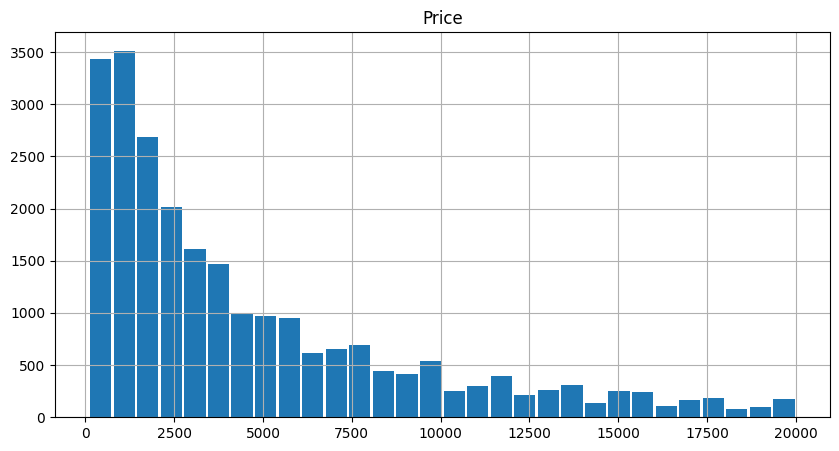

In [ ]:
# Удалим строки с ценной меньше 100

data = data[data['Price'] >= 100]

# Посмотрим распределение цены

data[['Price']].hist(bins=30, figsize=(10,5), rwidth=0.9)


In [ ]:
# Посмотрим выбросы в RegistrationYear

print('Количество выбросов в столбце RegistrationYear < 1950:',
      data[data['RegistrationYear'] < 1950]\
                          ['RegistrationYear'].count())
print('Количество выбросов в столбце RegistrationYear > 2022:',
      data[data['RegistrationYear'] > 2022]
                          ['RegistrationYear'].count())

Количество выбросов в столбце RegistrationYear < 1950: 10
Количество выбросов в столбце RegistrationYear > 2022: 5


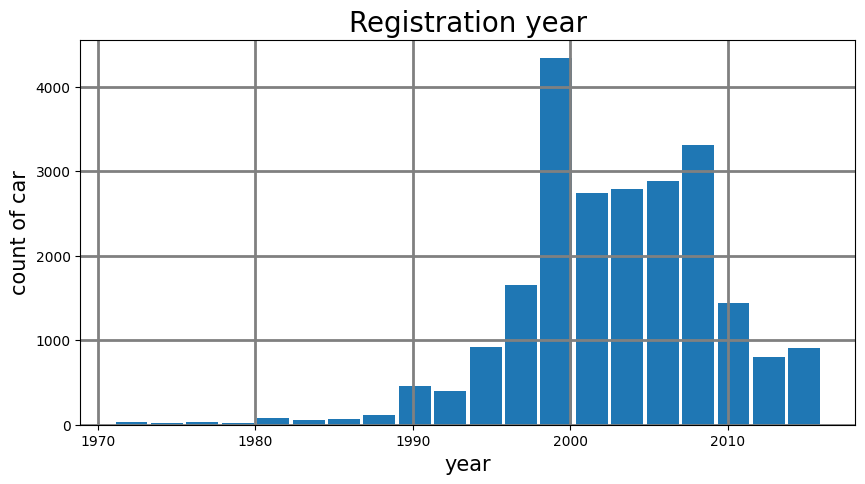

In [ ]:
# Найдём год последенего зарегестриованного объявления

last_year_ad = round(data.DateCreated.max())

# Удалим строки с датой регистрации ниже 1970г и выше last_year_ad

data = data[(data['RegistrationYear'] > 1970) &
            (data['RegistrationYear'] <= last_year_ad)]

# Построим распределение

plt.figure(figsize=(15,10))

data.RegistrationYear.plot.hist(bins=20, figsize=(10,5), rwidth=0.9)

plt.title('Registration year', fontsize=20)
plt.xlabel('year', fontsize=15)
plt.ylabel('count of car', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linewidth=2)
plt.show()


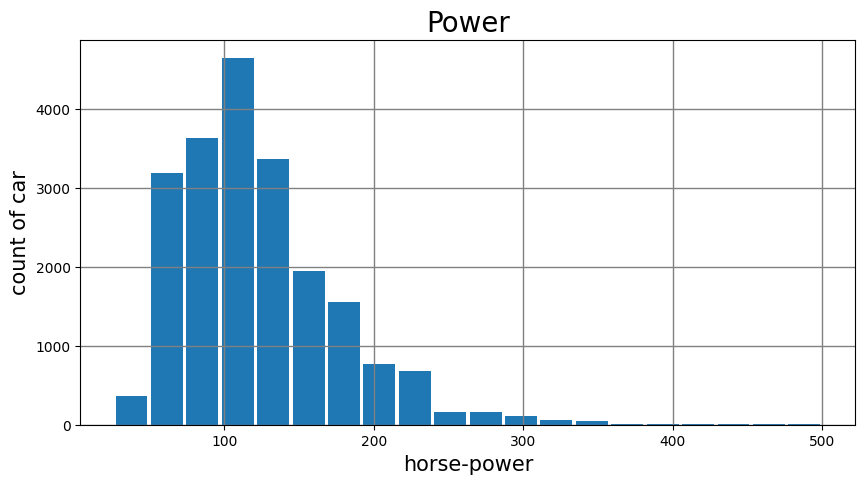

In [ ]:
# Удалим строки с количеством лошадиных сил меньше 25 и больше 500

data = data[(data.Power <= 500) &
            (data.Power >= 25)]

# Построим распределение

plt.figure(figsize=(15,10))

data.Power.plot.hist(bins=20, figsize=(10,5), rwidth=0.9)

plt.title('Power', fontsize=20)
plt.xlabel('horse-power', fontsize=15)
plt.ylabel('count of car', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='gray', linewidth=1)
plt.show()

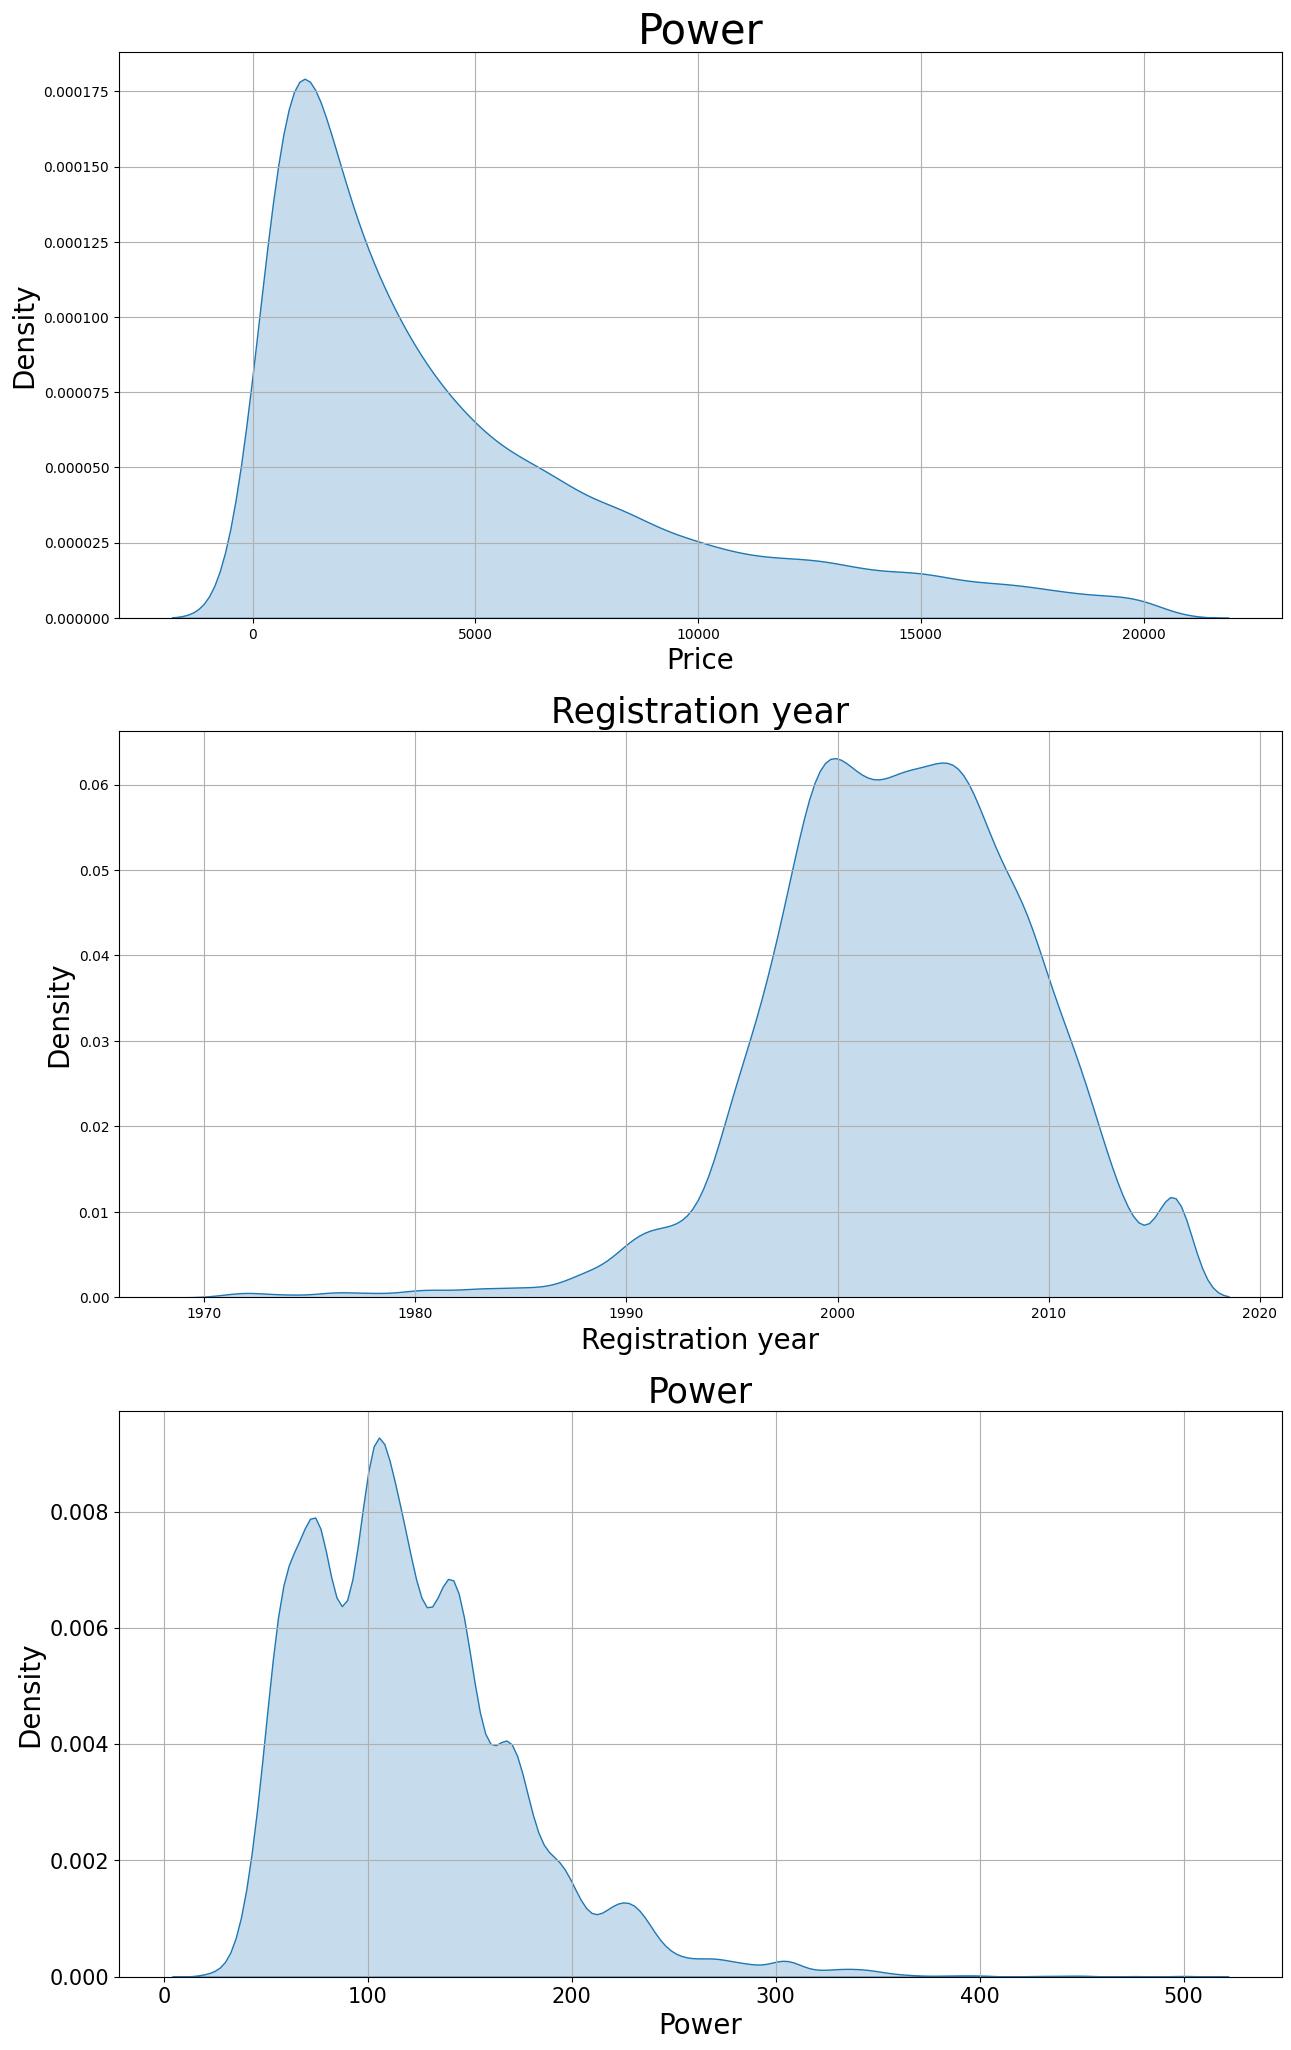

In [ ]:
# Построим в одном окне несколько графиков плотности распределения

_, axes = plt.subplots(3, 1, figsize=(15,25))

a = sns.kdeplot(data.Price, ax=axes[0], shade=True
                           ).set_title('Power', fontsize=30)
# a.axes.set_title('Power', fontsize=30)
a.axes.set_xlabel('Price', fontsize=20)
a.axes.set_ylabel('Density', fontsize=20)
a.axes.grid()

b = sns.kdeplot(data.RegistrationYear, ax=axes[1], shade=True
                                   ).set_title('Registration year', fontsize=25)
b.axes.set_xlabel('Registration year', fontsize=20)
b.axes.set_ylabel('Density', fontsize=20)
b.axes.grid()


c = sns.kdeplot(data.Power, ax=axes[2], shade=True
                                   ).set_title('Power', fontsize=25)
c.axes.set_xlabel('Power', fontsize=20)
c.axes.set_ylabel('Density', fontsize=20)
c.axes.grid()

# sns.set(font_scale=5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

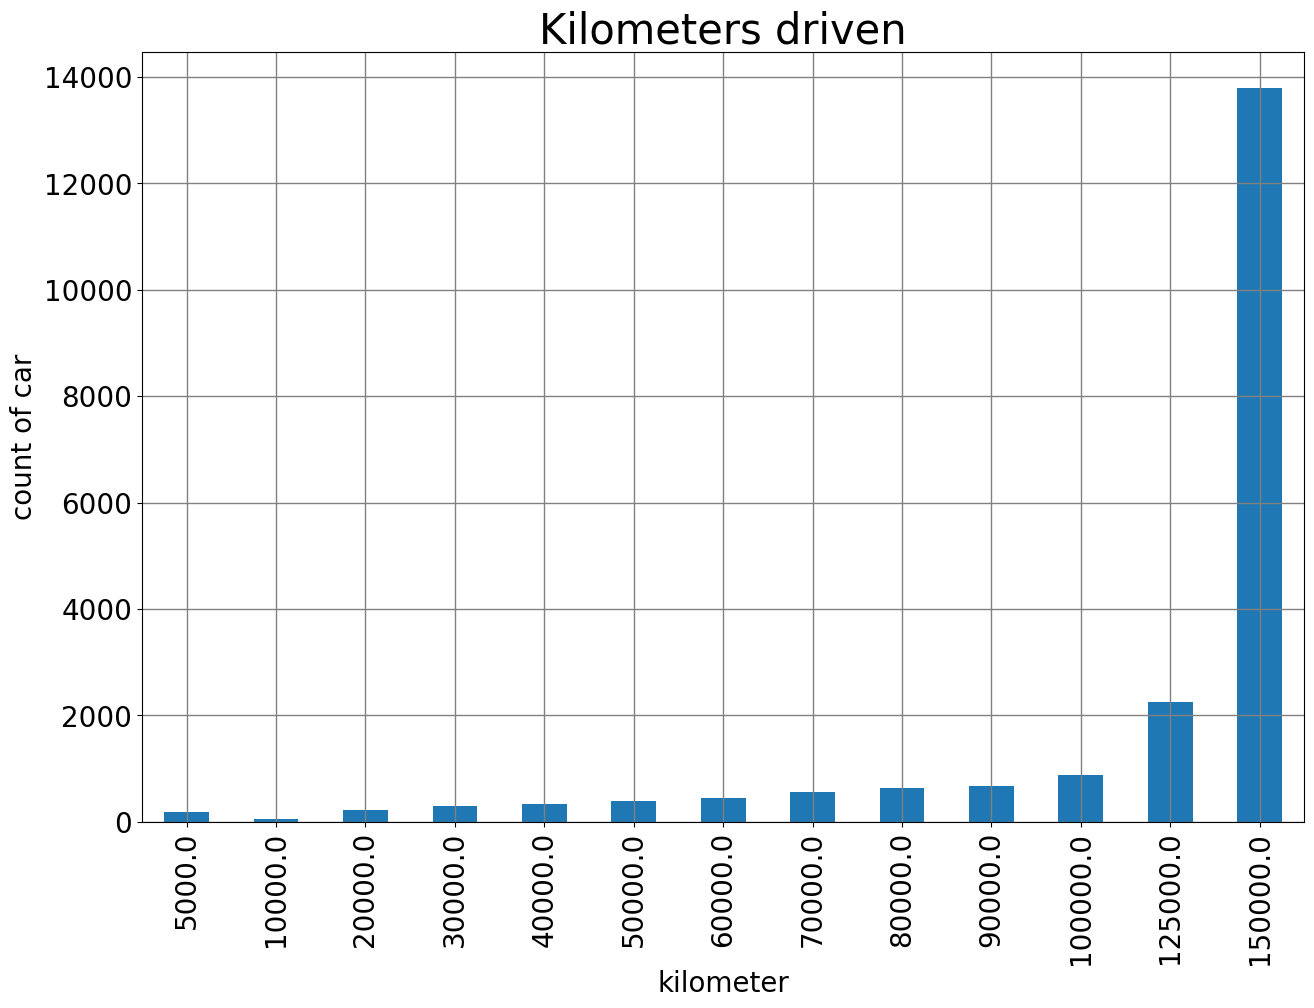

In [ ]:
# Построим распределение для столбца Kilometers

plt.figure(figsize=(15,10))

data.Kilometer.value_counts().sort_index().plot.bar()

plt.title('Kilometers driven', fontsize=30)
plt.xlabel('kilometer', fontsize=20)
plt.ylabel('count of car', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(color='gray', linewidth=1)
plt.show()

*Заметки:*<br/>
Хорошо видно, что  Kilometer принимает только определенные значения, поэтому этот признак можно считать категориальным.

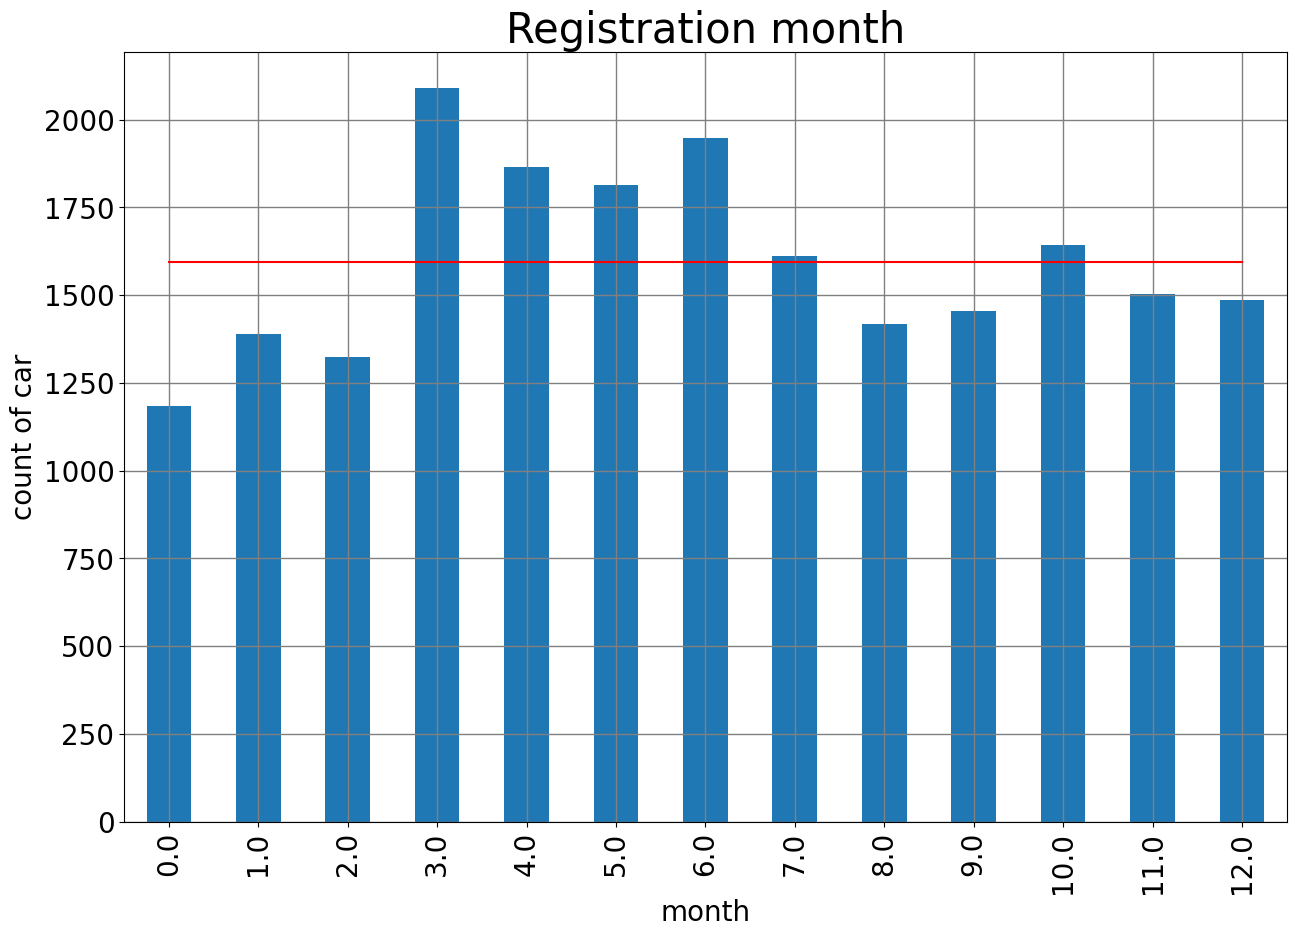

In [ ]:
# Построим распределение для столбца RegistrationMonth

plt.figure(figsize=(15,10))

data.RegistrationMonth.value_counts().sort_index().plot.bar()
plt.plot([data.RegistrationMonth.value_counts().mean()]*13, 'r')

plt.title('Registration month', fontsize=30)
plt.xlabel('month', fontsize=20)
plt.ylabel('count of car', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(color='gray', linewidth=1)
plt.show()

*Заметки:*
        
Аномалия, количество месяцев 13!

In [ ]:
# Посчитаем процент выкинутых строк

print(f'Процент выкинутых строк: '
      f'{(original_data.shape[0] - data.shape[0]) / original_data.shape[0]:.1%}')


Процент выкинутых строк: 17.5%


*Заметки:*
- В столбце Price есть выбросы, удалили строки с ценной меньше 100;
- В столбце RegistationYear есть выбросы, удалили строки с датой регистрации ниже 1950г и выше 2022г;
- В столбце Power есть выбросы, eдалили строки с количеством лошадиных сил меньше 25 и больше 500;
- Столбец Kilometers принимает дискретные значения, будем рассматривать как категориальный признак;
- В столбце RegistrationMonth есть нулевой месяц ??? Весной и в начале лета спрос на машины больше, что говорит о сезонности.
- Отбросили 14% строк.


In [ ]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
1,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes,2016.230769
2,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,NaN,2016.230769
3,1500.0,small,2001.0,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016.230769
4,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016.230769
5,650.0,sedan,1995.0,manual,102.0,3er,150000.0,10.0,petrol,bmw,yes,2016.307692


---

## Обработка пропусков

In [ ]:
# Посмотрим количесиво пропусков и
# уникальные значения в категориальных столбцах

print(data[['VehicleType', 'Gearbox',
                'FuelType', 'Repaired', 'Model']].isnull().sum())

print("VehicleType:", data['VehicleType'].unique(), '\n')
print("Gearbox:", data['Gearbox'].unique(), '\n')
print("FuelType:", data['FuelType'].unique(), '\n')
print("Repaired:", data['Repaired'].unique(), '\n')
print("Model:", data['Model'].unique())



VehicleType     770
Gearbox         356
FuelType       1079
Repaired       2892
Model           704
dtype: int64
VehicleType: ['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' nan 'other'] 

Gearbox: ['manual' 'auto' nan] 

FuelType: ['gasoline' 'petrol' nan 'lpg' 'other' 'hybrid' 'cng' 'electric'] 

Repaired: ['yes' nan 'no'] 

Model: [nan 'grand' 'golf' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'arosa' 'other'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one' 'fortwo'
 '1er' 'b_klasse' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito'
 'sprinter' 'astra' '156' 'escort' 'forester' 'xc_reihe' 'scenic' 'ka'
 'a1' 'focus' 'a4' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' 'combo' 'corsa'
 '80' '147' 'z_reihe' 'sorento' 'ibiza' 'mustang' 'eos' 'touran' 'getz'
 'insignia' 'almera' 'megane' 'a3' 'lupo' 'r19' 'caddy' 'mondeo' 'cordoba'
 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan' '6_reihe' 'c4' 'panda' 'up'
 'i_reih

In [ ]:
# Заменим пропуски в столбцах VehicleType, FuelType, Gearbox, Model на other

data.VehicleType.fillna(value='other', inplace=True)
data.Gearbox.fillna(value='other', inplace=True)
data.FuelType.fillna(value='other', inplace=True)
data.Model.fillna(value='other', inplace=True)

data[['VehicleType', 'Gearbox', 'FuelType', 'Model']].isnull().sum()


,0
VehicleType,0
Gearbox,0
FuelType,0
Model,0


In [ ]:
# Предположим, что пропуску в столбце  Repaired соответствует отсутствие ремонта

data.Repaired.fillna(value='no', inplace=True)

In [ ]:
# Проверим пропуски

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20733 entries, 1 to 25127
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              20733 non-null  float64
 1   VehicleType        20733 non-null  object 
 2   RegistrationYear   20733 non-null  float64
 3   Gearbox            20733 non-null  object 
 4   Power              20733 non-null  float64
 5   Model              20733 non-null  object 
 6   Kilometer          20733 non-null  float64
 7   RegistrationMonth  20733 non-null  float64
 8   FuelType           20733 non-null  object 
 9   Brand              20733 non-null  object 
 10  Repaired           20733 non-null  object 
 11  DateCreated        20733 non-null  float64
dtypes: float64(6), object(6)
memory usage: 2.1+ MB


___

## Разделение данных на выборки

In [ ]:
target = data['Price']
features = data.drop('Price', axis=1)

features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=.2, random_state=12345)

print(features_train.shape, features_test.shape)

(16586, 11) (4147, 11)


In [ ]:
# Сделаем переиндексацию после сплита

features_train = features_train.reset_index(drop=True)
features_test = features_test.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
0,small,2009.0,manual,60.0,polo,70000.0,4.0,petrol,volkswagen,no,2016.230769
1,small,1999.0,manual,75.0,colt,150000.0,4.0,lpg,mitsubishi,no,2016.230769
2,sedan,2006.0,manual,122.0,1er,125000.0,1.0,gasoline,bmw,no,2016.230769
3,small,2000.0,manual,60.0,clio,150000.0,6.0,petrol,renault,no,2016.307692
4,sedan,2001.0,manual,192.0,3er,150000.0,6.0,petrol,bmw,no,2016.307692


---

## Преобразование категориальных признаков

In [ ]:
# Данные в столбце Repaired имеет только 2 возможных значения,
# это категориальный бинарный признак и его можно напрямую заменить на 0 и 1.

features_train['Repaired'] = features_train['Repaired'].map({'no': 0, 'yes': 1})

features_train.Repaired.head()

,Repaired
0,0
1,0
2,0
3,0
4,0


In [ ]:
# Категориальные признаки для OHE

cat_features = features_train.select_dtypes(include='object').columns.to_list()

cat_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']

In [ ]:
# Числовые признаки

num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('Repaired') # Преобразован выше
num_features

['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'DateCreated']

In [ ]:
# Для модели решающего дерева приведём объекты
# к числовым значениям по методу порядкового кодирования

# encoder = OrdinalEncoder()
# data_tree = pd.DataFrame(encoder.fit_transform(features_train),  # кодирование применяется ко всем признакам
#                          columns=features_train.columns)

# sorted(data_tree.VehicleType.unique())

In [ ]:
# Для модели решающего дерева приведём объекты
# к числовым значениям по методу порядкового кодирования.

features_tree_train = features_train.copy(deep=True)
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value',  # Неизвестным категориям присваевается "-1"
                            unknown_value=-1)
features_tree_train[cat_features] = encoder_oe.fit_transform(features_tree_train[cat_features])

features_tree_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated
0,5.0,2009.0,1.0,60.0,164.0,70000.0,4.0,6.0,38.0,0,2016.230769
1,5.0,1999.0,1.0,75.0,77.0,150000.0,4.0,4.0,22.0,0,2016.230769
2,4.0,2006.0,1.0,122.0,6.0,125000.0,1.0,2.0,2.0,0,2016.230769
3,5.0,2000.0,1.0,60.0,74.0,150000.0,6.0,6.0,27.0,0,2016.307692
4,4.0,2001.0,1.0,192.0,11.0,150000.0,6.0,6.0,2.0,0,2016.307692


In [ ]:
# Для линейной ригресии преобразуем кат. признаки в числовые значения
# по методу прямого кодирования.

# features_train_regr = pd.get_dummies(features_train,
#                                  columns=cat_features,
#                                  prefix=cat_features,
#                                  prefix_sep='_',
#                                  drop_first=True)

# features_test_regr = pd.get_dummies(features_test,
#                                  columns=cat_features,
#                                  prefix=cat_features,
#                                  prefix_sep='_',
#                                  drop_first=True)

# features_train_regr.head()

*Заметки:*
- get_dummies подходит для анализа данных, а для машинного обучения более предпочтителен OHE, т.к. он позоволяет избежать ряд ошибок при обучении моделей, в том числе может работать с неизвестными ранее уровнями категорий, которых не было изначально (например, если появится еще одна модель машины).
- get_dummies также нельзя использовать вместе с pipeline, column_transformer, ecли появляется новая выборка и ее нужно кодировать, то обязательно стоит выполнить проверку, чтобы получившиеся фичи были такие же.
- По аналогии с масштабированием делаем fit только на трейне, а transform на всех выборках.
- Чтобы оба параметра handle_unknown и drop_first работали одновременно в OneHotEncoder(drop='first', handle_unknown='ignore'), нужно установить последнюю версию sklearn.
- Возможна разния запись для преобразованияOneHotEncoder:

```python
features_tree_train[num_features] = encoder_oe.transform(features_tree_train[num_features])
```  
или сразу преобразуем в датафрейм
```python
data_tree = pd.DataFrame(encoder.transform(data), columns=data.columns)
```

In [ ]:
# Преобразование категориальных признаков по методу OHE
# для линейной ригресии

features_regr_train = features_train.copy(deep=True)
encoder_ohe = OneHotEncoder(drop='first',
                            handle_unknown='ignore',
                            # sparse_out=True  # по умолчанию данные возвращаюся в виде sparse matrix
                            )
ohe_data = encoder_ohe.fit_transform(features_regr_train[cat_features]. \
                                     values.reshape(-1,len(cat_features))).toarray()
res = pd.DataFrame(ohe_data)
features_regr_train = pd.concat([features_regr_train, res], axis=1)
features_regr_train = features_regr_train.drop(cat_features, axis=1)

print(features_regr_train.shape)
display(features_regr_train.head())

(16586, 292)


,RegistrationYear,Power,Kilometer,RegistrationMonth,Repaired,DateCreated,0,1,2,3,...,276,277,278,279,280,281,282,283,284,285
0,2009.0,60.0,70000.0,4.0,0,2016.230769,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1999.0,75.0,150000.0,4.0,0,2016.230769,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006.0,122.0,125000.0,1.0,0,2016.230769,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000.0,60.0,150000.0,6.0,0,2016.307692,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2001.0,192.0,150000.0,6.0,0,2016.307692,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

## Масштабирование признаков

In [ ]:
# Масштабируем признаки для линейной регрессии

features_regr_train_sc = features_regr_train.copy(deep=True)
scaler = StandardScaler()
features_regr_train_sc[num_features] = scaler.fit_transform(
                                    features_regr_train_sc[num_features])

features_regr_train_sc.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,Repaired,DateCreated,0,1,2,3,...,276,277,278,279,280,281,282,283,284,285
0,0.969735,-1.131772,-1.588620,-0.571726,0,-0.420908,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.651459,-0.853768,0.589658,-0.571726,0,-0.420908,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.483377,0.017310,-0.091054,-1.411864,0,-0.420908,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.489339,-1.131772,0.589658,-0.011633,0,2.120475,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.327220,1.314660,0.589658,-0.011633,0,2.120475,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

## Преобразование признаков методом make_column_transformer

In [ ]:
# Используем make_column_transformer для кодирования и масштабирования признаков
# для линейной регрессии

features_regr_train_tr = features_train.copy(deep=True)

col_transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop='first'), cat_features),
    (StandardScaler(), num_features),
     remainder='passthrough'
)
transformed = col_transformer.fit_transform(features_regr_train_tr)
column_names = (col_transformer.named_transformers_['onehotencoder'].\
                get_feature_names_out().tolist() +
                num_features + ['Repaired'])

# Собирём датафрейм из преобразованных признаков
features_regr_train_tr = pd.DataFrame(transformed,
                                      columns=column_names)
features_regr_train_tr.head()

,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,Gearbox_manual,Gearbox_other,Model_145,...,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,Repaired
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.969735,-1.131772,-1.588620,-0.571726,-0.420908,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.651459,-0.853768,0.589658,-0.571726,-0.420908,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.483377,0.017310,-0.091054,-1.411864,-0.420908,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.489339,-1.131772,0.589658,-0.011633,2.120475,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.327220,1.314660,0.589658,-0.011633,2.120475,0.0


---

# Обучение моделей

In [ ]:
# Функция для вычисления метрики RMSE

def RMSE(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)**.5
    # print('RSME: ', round(rmse))
    return rmse

scorer = make_scorer(RMSE, greater_is_better=False)

## Модель решающего дерева

*Заметки:*
    
Для моделей на основе деревьев решений подходит порядковое кодирование.

### Обучение и проверка модели

In [ ]:
%%time

# Подбор гиперпараметров с использованием метода кросс-валидации.

grid_dtr = GridSearchCV(DecisionTreeRegressor(),
                        param_grid={'max_depth': range(6, 12)},
                        scoring=scorer,
                        cv=KFold(5, shuffle=True, random_state=12345))

grid_dtr.fit(features_tree_train, target_train)
grid_dtr.best_params_, round(grid_dtr.best_score_)

CPU times: user 1.3 s, sys: 3 ms, total: 1.3 s
Wall time: 1.34 s


({'max_depth': 8}, -2244)

In [ ]:
# Обучим модель решающего дерева
# (GridSearchCV выше даёт лучший резултат при глубине 11)

start_time = time.time()

regr_dtr = DecisionTreeRegressor(max_depth=8,
                                 random_state=12345).fit(features_tree_train,
                                                         target_train)

fit_time_dtr = time.time() - start_time

print(f'Время обучения модели DecisionTree: {fit_time_dtr:.2f} s')


Время обучения модели DecisionTree: 0.04 s


In [ ]:
# Вычислим время предсказания на тренировочной выборке

start_time = time.time()

pred_dtr = regr_dtr.predict(features_tree_train)
rmse_dtr = RMSE(target_train, pred_dtr)

pred_time_dtr = time.time() - start_time

print(f'Время предсказания модели DecisionTree: {pred_time_dtr:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_dtr:.0f}')

Время предсказания модели DecisionTree: 0.01 s
RMSE на тренировочной выборке: 1944


In [ ]:
# Проверка RMSE модели на кросс-валидации.

scores_dtr = cross_val_score(regr_dtr,
                             features_tree_train,
                             target_train,
                             cv=5,  # по умолчанию
                             scoring=scorer)

print(f'среднее значение RMSE модели DecisionTree: {abs(scores_dtr.mean()):.0f}')

среднее значение RMSE модели DecisionTree: 2246


In [ ]:
# Создадим датафрейм c результатами

df_results = pd.DataFrame(columns=['model', 'rmse','fit_time', 'pred_time'])

# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['DecisionTreeRegressor',
                                   round(scores_dtr.mean() * (-1)),
                                   round(fit_time_dtr, 2),
                                   round(pred_time_dtr, 2)]
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01


_____

### Проверка значимости признаков

In [ ]:
# Упорядочим признаки по значимости,
# используем метод feature_importances_

for name, importance in sorted(zip(features_tree_train.columns,
                                   regr_dtr.feature_importances_),
                               key=lambda x: -x[1]):
    print(f'{name} : {round(importance, 2)}')


RegistrationYear : 0.6
Power : 0.3
Kilometer : 0.05
VehicleType : 0.01
Brand : 0.01
Repaired : 0.01
Model : 0.0
RegistrationMonth : 0.0
FuelType : 0.0
DateCreated : 0.0
Gearbox : 0.0


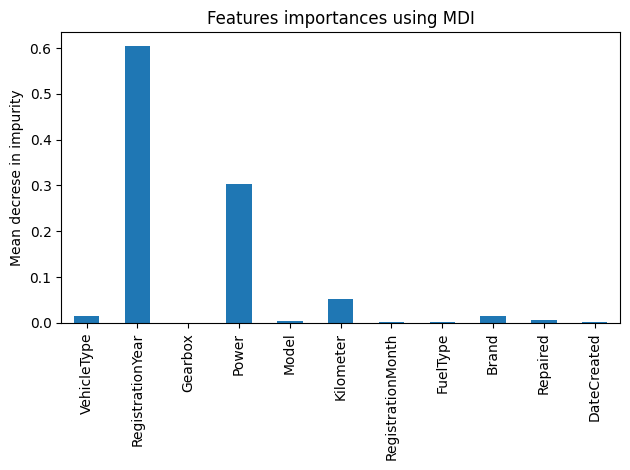

In [ ]:
# Построим столбчатую диаграмму по значимости признаков.

tree_importances = pd.Series(regr_dtr.feature_importances_,
                             index=features_tree_train.columns)

ax = tree_importances.plot.bar()
ax.set_title('Features importances using MDI')
ax.set_ylabel('Mean decrese in impurity')
plt.tight_layout()

In [ ]:
# Упорядочим признаки по значимости,
# используем метод permutation_importances_

r = permutation_importance(regr_dtr,
                features_tree_train, target_train,
                           n_repeats=30, random_state=12345)

for i in r.importances_mean.argsort()[::-1]:
    print(f'{features_tree_train.columns[i]}'
          f' {r.importances_mean[i]:.3f} '
          f'+/- {r.importances_std[i]:.3f}')

RegistrationYear 0.914 +/- 0.010
Power 0.570 +/- 0.009
Kilometer 0.081 +/- 0.003
Brand 0.037 +/- 0.002
VehicleType 0.035 +/- 0.002
Repaired 0.013 +/- 0.001
Model 0.010 +/- 0.001
RegistrationMonth 0.004 +/- 0.001
FuelType 0.003 +/- 0.000
DateCreated 0.001 +/- 0.000
Gearbox 0.001 +/- 0.000


*Заметки:*
- Как ожидалось, наибольшую значимость в оценке стоимости авто играет RegistrationYear, Power, Kilometer. В меньшей степени на стоимость влияет Brand, VehicleType, Model, Repaired, FuelType.
- Признаки Gearbox, RegistrationMonth, DateCreated мало влияют на стоимость и могут быть отброшены для ускорения модели. RegistrationMonth можно добавить к году, как дробную часть.

---

## Модель случайного леса

In [ ]:
%%time

# Подбор гиперпараметров методом кросс-валидации

grid_rfr = RandomizedSearchCV(RandomForestRegressor(),
                              {'max_depth': range(6, 12),
                               'n_estimators': [50,100,200,400,800]},
                               scoring=scorer,
                               n_iter=3, cv=5, random_state=12345)
grid_rfr.fit(features_tree_train, target_train)
grid_rfr.best_params_, round(grid_rfr.best_score_)

CPU times: user 1min 37s, sys: 27.4 ms, total: 1min 37s
Wall time: 1min 48s


({'n_estimators': 100, 'max_depth': 11}, -1928)

In [ ]:
# Обучим модель
# (RandomizedSearchCV даёт лучший результат при max_depth=11 и n_estimators=100)'

start_time = time.time()

regr_rfr = RandomForestRegressor(max_depth=11,
                                 n_estimators=100,
                                 random_state=12345).\
                                        fit(features_tree_train, target_train)

fit_time_rfr = time.time() - start_time

print(f'Время обучения модели RandomForest: {fit_time_rfr:.2f} s')

Время обучения модели RandomForest: 6.10 s


In [ ]:
# Время предсказания на тренировочной выборке.

start_time = time.time()

pred_rfr = regr_rfr.predict(features_tree_train)
rmse_rfr = RMSE(target_train, pred_rfr)

pred_time_rfr = time.time() - start_time

print(f'Время предсказания модели RandomForest: {pred_time_rfr:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_rfr:.0f}')


Время предсказания модели RandomForest: 0.21 s
RMSE на тренировочной выборке: 1351


In [ ]:
# Проверка RMSE модели на кросс-валидации.

scores_rfr = cross_val_score(regr_rfr,
                             features_tree_train,
                             target_train,
                             cv=5,  # по умолчанию
                             scoring=scorer)

print(f'среднее значение RMSE модели RandomForest: {abs(scores_rfr.mean()):.0f}')

среднее значение RMSE модели RandomForest: 1931


In [ ]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['RandomForestRegressor',
                                   round(scores_rfr.mean()*(-1)),
                                   round(fit_time_rfr, 2),
                                   round(pred_time_rfr, 2)]
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01
1,RandomForestRegressor,1931,6.10,0.21


---

## Модель линейной регрессии

In [ ]:
# Обучим модель

start_time = time.time()

regr_lr = LinearRegression().fit(features_regr_train_tr,
                                 target_train)

fit_time_lr = time.time() - start_time

print(f'Время обучения модели LinearRegression: {fit_time_lr:.2f} s')

Время обучения модели LinearRegression: 0.50 s


In [ ]:
# Время предсказания на тренировочной выборке.

start_time = time.time()

pred_lr = regr_lr.predict(features_regr_train_tr)
rmse_lr = RMSE(target_train, pred_lr)

pred_time_lr = time.time() - start_time

print(f'Время предсказания модели LinearRegression: {pred_time_lr:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_lr:.0f}')


Время предсказания модели LinearRegression: 0.02 s
RMSE на тренировочной выборке: 2520


In [ ]:
# Проверка RMSE модели на кросс-валидации.

scores_lr = cross_val_score(regr_lr,
                            features_regr_train_tr,
                            target_train,
                            cv=5,  # по умолчанию
                            scoring=scorer)
print(f'среднее значение RMSE модели LinearRegression: {abs(scores_lr.mean()):.0f}')

среднее значение RMSE модели LinearRegression: 2588


In [ ]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['LinearRegression',
                                   round(scores_lr.mean()*(-1)),
                                   round(fit_time_lr, 2),
                                   round(pred_time_lr, 2)]
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01
1,RandomForestRegressor,1931,6.10,0.21
2,LinearRegression,2588,0.50,0.02


---

## Модель CatBoost

*Заметки:*
    
Для CatBoost можно использовать либо встроенный алгоритм кодирования (то есть подавать модели незакодированные предварительно фичи), либо порядковое кодирование, а унитарное кодирование (OHE) стоит исключить.

### CatBoost + OrdinalEncorder features

In [ ]:
# Обучим модель

start_time = time.time()

catbooster_oe = CatBoostRegressor(loss_function='RMSE',  # по умолчанию
                                  iterations=100,  # по умолчанию iterations=1000
                                  learning_rate=0.1,  # по умолчанию learning_rate=0.03
                                  depth=8)
catbooster_oe.fit(features_tree_train,
                  target_train,
                  verbose=False,
                  plot=False)

fit_time_catbooster_oe = time.time() - start_time

print(f'Время обучения модели CatBoost: {fit_time_catbooster_oe:.2f} s')

Время обучения модели CatBoost: 0.65 s


In [ ]:
# Время предсказания модели на тренировочной выборке.

start_time = time.time()

pred_catbooster_oe = catbooster_oe.predict(features_tree_train)
rmse_catbooster_oe = RMSE(target_train, pred_catbooster_oe)

pred_time_catbooster_oe = time.time() - start_time

print(f'Время предсазания модели CatBoost: {pred_time_catbooster_oe:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_catbooster_oe:.0f}')

Время предсазания модели CatBoost: 0.01 s
RMSE на тренировочной выборке: 1647


Training on fold [0/5]

bestTest = 1888.360552
bestIteration = 99

Training on fold [1/5]

bestTest = 1759.457499
bestIteration = 99

Training on fold [2/5]

bestTest = 1819.077951
bestIteration = 99

Training on fold [3/5]

bestTest = 1846.733076
bestIteration = 99

Training on fold [4/5]

bestTest = 2017.846819
bestIteration = 99

Среднее значение RMSE для модели CatBoost: 1866


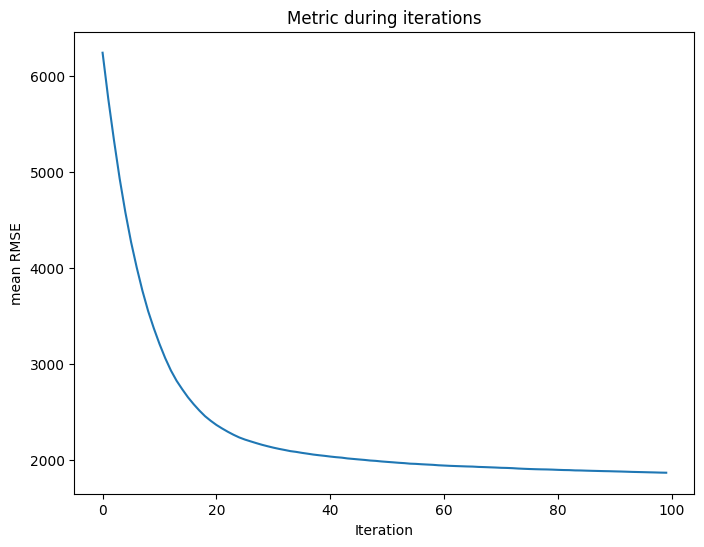

In [ ]:
# Зададим гиперпараметры модели

cv_params_cat = {"loss_function": 'RMSE',
                 "custom_metric": 'RMSE',
                 "iterations": 100,
                 "learning_rate": 0.1,
                 "random_seed": 42,
                 "use_best_model": False}

# Запустим обучение с кросс-валидацией

catbooster_oe_cv = cv(pool=Pool(features_tree_train, label=target_train),
                      params=cv_params_cat,
                      fold_count=5,  # По умолчанию 3
                      partition_random_seed=0, # По умолчанию
                      shuffle=True, # По умолчанию
                      verbose=False)

mean_rmse_catbooster_oe = catbooster_oe_cv['test-RMSE-mean'].min()

print(f'Среднее значение RMSE для модели CatBoost: {mean_rmse_catbooster_oe:.0f}')

# Визуализация сходимости метрики

plt.figure(figsize=(8,6))
plt.plot(catbooster_oe_cv['test-RMSE-mean'])
plt.title('Metric during iterations')
plt.xlabel('Iteration')
plt.ylabel('mean RMSE')
plt.show()

In [ ]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['CatBoostRegressor(OE)',
                                   round(mean_rmse_catbooster_oe),
                                   round(fit_time_catbooster_oe, 2),
                                   round(pred_time_catbooster_oe, 2)]
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01
1,RandomForestRegressor,1931,6.10,0.21
2,LinearRegression,2588,0.50,0.02
3,CatBoostRegressor(OE),1866,0.65,0.01


---

### CatBoost + raw catfeatures

In [ ]:
# Обучим модель

start_time = time.time()

catbooster_raw = CatBoostRegressor(iterations=100,
                                   learning_rate = 0.1,
                                   depth=8)
catbooster_raw.fit(features_train,
                   target_train,
                   cat_features=cat_features,
                   verbose=False,
                   plot=False)

fit_time_catbooster_raw = time.time() - start_time

print(f'Время обучения модели CatBoost: {fit_time_catbooster_raw:.2f} s')

Время обучения модели CatBoost: 2.02 s


In [ ]:
# Время предсказания модели на тренировочной выборке.

start_time = time.time()

pred_catbooster_raw = catbooster_raw.predict(features_train)
rmse_catbooster_raw = RMSE(target_train, pred_catbooster_raw)

pred_time_catbooster_raw = time.time() - start_time

print(f'Время предсказания модели CatBoost: {pred_time_catbooster_raw:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_catbooster_raw:.0f}')

Время предсказания модели CatBoost: 0.03 s
RMSE на тренировочной выборке: 1618


Training on fold [0/5]

bestTest = 1847.711311
bestIteration = 99

Training on fold [1/5]

bestTest = 1748.488529
bestIteration = 98

Training on fold [2/5]

bestTest = 1759.099785
bestIteration = 98

Training on fold [3/5]

bestTest = 1816.715399
bestIteration = 98

Training on fold [4/5]

bestTest = 2015.792222
bestIteration = 99

Среднее значение RMSE модели Catboost: 1838


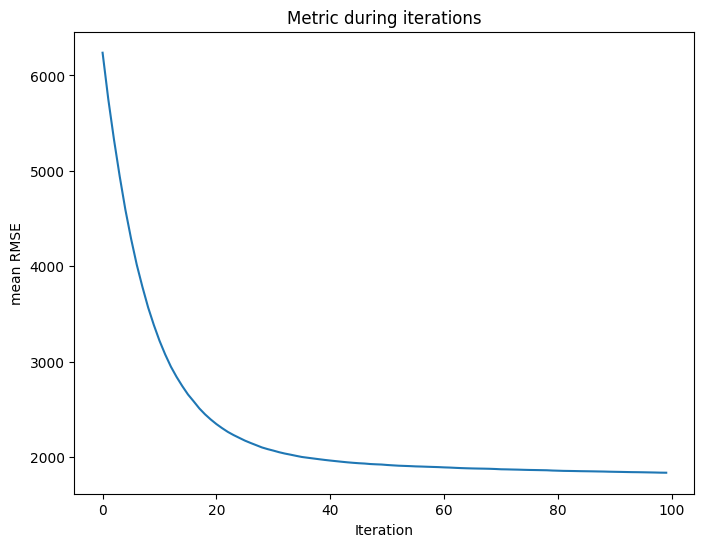

In [ ]:
# Запустим обучение с кросс-валидацией

catbooster_raw_cv = cv(pool=Pool(features_train,
                                 label=target_train,
                                 cat_features=cat_features),
                       params=cv_params_cat,
                       fold_count=5,  # По умолчанию 3
                       partition_random_seed=0, # По умолчанию
                       shuffle=True, # По умолчанию
                       verbose=False)

mean_rmse_catbooster_raw = catbooster_raw_cv['test-RMSE-mean'].min()

print(f'Среднее значение RMSE модели Catboost: {mean_rmse_catbooster_raw:.0f}')

# Визуализация сходимости метрики

plt.figure(figsize=(8,6))
plt.plot(catbooster_raw_cv['test-RMSE-mean'])
plt.title('Metric during iterations')
plt.xlabel('Iteration')
plt.ylabel('mean RMSE')
plt.show()

In [ ]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['CatBoostRegressor(raw_cat)',
                                   round(mean_rmse_catbooster_raw),
                                   round(fit_time_catbooster_raw, 2),
                                   round(pred_time_catbooster_raw, 2)]
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01
1,RandomForestRegressor,1931,6.10,0.21
2,LinearRegression,2588,0.50,0.02
3,CatBoostRegressor(OE),1866,0.65,0.01
4,CatBoostRegressor(raw_cat),1838,2.02,0.03


---

###  CatBoost + raw catfeatures + ignored unimportant features

In [ ]:
# Обучим модель

start_time = time.time()

ignored_features = ['Gearbox', 'FuelType', 'DateCreated']  # Признаки отобраны из проверки значимости выше

catbooster_raw_ignored = CatBoostRegressor(iterations=100,
                                           ignored_features=ignored_features,
                                           learning_rate = 0.1,
                                           depth=8)
catbooster_raw_ignored.fit(features_train,
                           target_train,
                           cat_features=cat_features,
                           verbose=False,
                           plot=False)

fit_time_catbooster_raw_ignored = time.time() - start_time

print(f'Время обучения модели CatBoost: {fit_time_catbooster_raw_ignored:.2f} s')

Время обучения модели CatBoost: 1.01 s


In [ ]:
# Время предсказания модели на тренировочной выборке.

start_time = time.time()

pred_catbooster_raw_ignored = catbooster_raw_ignored.predict(features_train)
rmse_catbooster_raw_ignored = RMSE(target_train, pred_catbooster_raw_ignored)

pred_time_catbooster_raw_ignored = time.time() - start_time

print(f'Время предсказания модели CatBoost: {pred_time_catbooster_raw_ignored:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_catbooster_raw_ignored:.0f}')

Время предсказания модели CatBoost: 0.02 s
RMSE на тренировочной выборке: 1634


In [ ]:
# Зададим гиперпараметры модели

cv_params_cat = {"loss_function": 'RMSE',
                 "custom_metric": 'RMSE',
                 "iterations": 100,
                 "learning_rate": 0.1,
                 "random_seed": 42,
                 "use_best_model": False,
                 "ignored_features": ignored_features}

# Запустим обучение с кросс-валидацией

catbooster_raw_ignored_cv = cv(pool=Pool(features_train,
                                         label=target_train,
                                         cat_features=cat_features),
                               params=cv_params_cat,
                               fold_count=5,  # По умолчанию 3
                               partition_random_seed=0, # По умолчанию
                               shuffle=True, # По умолчанию
                               verbose=False)

mean_rmse_catbooster_raw_ignored = catbooster_raw_ignored_cv['test-RMSE-mean'].min()

print(f'Среднее значение RMSE модели CatBoost: {mean_rmse_catbooster_raw_ignored:.0f}')

Training on fold [0/5]

bestTest = 1876.499968
bestIteration = 99

Training on fold [1/5]

bestTest = 1744.536522
bestIteration = 99

Training on fold [2/5]

bestTest = 1762.07542
bestIteration = 99

Training on fold [3/5]

bestTest = 1819.076169
bestIteration = 99

Training on fold [4/5]

bestTest = 2013.500401
bestIteration = 98

Среднее значение RMSE модели CatBoost: 1843


In [ ]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['CatBoost(raw_cat_ignored)',
                                   round(mean_rmse_catbooster_raw_ignored),
                                   round(fit_time_catbooster_raw_ignored, 2),
                                   round(pred_time_catbooster_raw_ignored, 2)]
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01
1,RandomForestRegressor,1931,6.10,0.21
2,LinearRegression,2588,0.50,0.02
3,CatBoostRegressor(OE),1866,0.65,0.01
4,CatBoostRegressor(raw_cat),1838,2.02,0.03
5,CatBoost(raw_cat_ignored),1843,1.01,0.02


___

## Модель LightGBM

### LightGBM + OrdinalEncorder features

*Заметки:*        
        
- Для LightGBM также можно использовать встроенный кодер, то есть подавать незакодированные предварительно фичи, хотя порядковое кодирование тоже подходит.
- Для кросс-валлидации нужно использовать LightGBM с методом fit, а не train.

In [ ]:
# Обучим модель с методом train

start_time = time.time()

# Подготовим признаки

train_dataset = lgb.Dataset(features_tree_train, target_train,
                            feature_name=features_tree_train.columns.tolist())
# Зададим гиперпараметры мимодели

params_lgb_train = {"boosting_type": "gbdt",
                    "objective": "regression",
                    "metric": {"rmse"},
                    "learning_rate": 0.1, # По умолчанию
                    "num_leaves": 31, # По умолчанию
                    "n_estimators": 100, # По умолчанию
                    "verbose": 0,
                    "random_state": 12345}

lgb_booster_oe = lgb.train(params_lgb_train,
                           train_set=train_dataset,
                           #valid_sets=test_dataset,
                           num_boost_round=100)  # По умолчанию

fit_time_lgb_oe = time.time() - start_time

print(f'Время обучения модели LightGBM: {fit_time_lgb_oe:.2f} s')

Время обучения модели LightGBM: 0.21 s


In [ ]:
# Время предсказания модели на тренировочной выборке.

start_time = time.time()

pred_lgb_oe = lgb_booster_oe.predict(features_tree_train)
rmse_lgb_oe = RMSE(target_train, pred_lgb_oe)

pred_time_lgb_oe = time.time() - start_time

print(f'Время предсказания модели LightGBM: {pred_time_lgb_oe:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_lgb_oe:.0f}')

Время предсказания модели LightGBM: 0.08 s
RMSE на тренировочной выборке: 1540


In [ ]:
# Обучим модель с методом fit

start_time = time.time()

boost_LGB = lgb.LGBMRegressor(learning_rate=0.1,  # По умолчанию
                              num_leaves=31,  # По умолчанию
                              n_estimators=100,  # По умолчанию
                              num_iterations=100,  # По умолчанию
                              random_state=12345,
                              verbose=-1)

regr_LGB = boost_LGB.fit(features_tree_train, target_train)

fit_time_lgb_oe_ = time.time() - start_time

print(f'Время обучения модели: {fit_time_lgb_oe_:.2f} s')

Время обучения модели: 0.22 s


In [ ]:
# Время предсказания модели на тренировочной выборке.

start_time = time.time()

pred_lgb_oe_ = boost_LGB.predict(features_tree_train)
rmse_lgb_oe_ = RMSE(target_train, pred_lgb_oe_)

pred_time_lgb_oe_ = time.time() - start_time

print(f'Время предсказания модели LightGBM: {pred_time_catbooster_raw_ignored:.2f} s')
print(f'RMSE на тренировочной выборке: {rmse_lgb_oe_:.0f}')

Время предсказания модели LightGBM: 0.02 s
RMSE на тренировочной выборке: 1540


In [ ]:
# Проверка модели на кросс-валидации

scores_lgb = cross_val_score(regr_LGB,
                             features_tree_train,
                             target_train,
                             cv=5,  # по умолчанию
                             scoring=scorer)

print(f'Среднее значение RMSE модели LightGBM: {abs(scores_lgb.mean()):.0f}')

Среднее значение RMSE модели LightGBM: 1791


In [ ]:
# Добавим строку к фрейму с результатами

df_results.loc[len(df_results)] = ['LightGBM',
                                   abs(round(scores_lgb.mean())),
                                   round(fit_time_lgb_oe_, 2),
                                   round(pred_time_lgb_oe_, 2)]
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01
1,RandomForestRegressor,1931,6.10,0.21
2,LinearRegression,2588,0.50,0.02
3,CatBoostRegressor(OE),1866,0.65,0.01
4,CatBoostRegressor(raw_cat),1838,2.02,0.03
5,CatBoost(raw_cat_ignored),1843,1.01,0.02
6,LightGBM,1791,0.22,0.13


---

# Анализ моделей

Результаты рассчётов для различных моделей собраны в таблице выше: тип модели, метрика RMSE, время обучения, время предсказания.

In [ ]:
df_results

,model,rmse,fit_time,pred_time
0,DecisionTreeRegressor,2246,0.04,0.01
1,RandomForestRegressor,1931,6.10,0.21
2,LinearRegression,2588,0.50,0.02
3,CatBoostRegressor(OE),1866,0.65,0.01
4,CatBoostRegressor(raw_cat),1838,2.02,0.03
5,CatBoost(raw_cat_ignored),1843,1.01,0.02
6,LightGBM,1791,0.22,0.13


*Заключение:*
- Наилучшее качество по метрике RMSE получается для моделей бустинга;
- Модель LightGBM обучаются быстрее, чем Catboost и на данных с порядковым кодированием, но Catboost предсказывает заметно быстрее, чем модель LightGBM;
- Модель Catboost обученная на сырых данных имеет значение RMSE, , но время обучения возрастает;
- Если откинуть маловажные признаки Gearbox, RegistrationMonth, DateCreated, то время обучения модели Catboost снижается, но точность немного падает;
- Меняя количество деревьев в ансамбле можно управлять скоростью обучения моделей бустинга, оптимальное значение количетва деревьев - 100.

***Вывод:***
Модель Catboost немного уступает модели LightGBM по метрике RMSE, но делает предсказывает заметно быстрее, поэтому для предсказания стоимости автомобиля рекомендуется использовать модель Catboost с глубиной деревьев 8 и колличеством деревьев в ансамбле 100.
На тестовой выборке сравним время обучения и предсказания модели с сырыми данными и преобразованными по методу OrdinalEncorder.

____

# Тестирование модели

In [ ]:
# Проверка модели CatBoost на тестовой выборке c порядковым кодированием

start_time = time.time()

features_test_oe = features_test.copy(deep=True)
features_test_oe['Repaired'] = features_test_oe['Repaired'].map({'no': 0, 'yes': 1})
features_test_oe[cat_features] = encoder_oe.transform(features_test_oe[cat_features])

pred_catbooster_test = catbooster_oe.predict(features_test_oe)
rmse_catbooster_test = RMSE(target_test, pred_catbooster_test)

pred_time_catbooster_test = time.time() - start_time

print(f'Время предсказания: {pred_time_catbooster_test:.2f}')
print(f'RMSE на тестовой выборке: {rmse_catbooster_test:.0f}')


Время предсказания: 0.03
RMSE на тестовой выборке: 1744


In [ ]:
# Проверка модели CatBoost на тестовой выборке c сырыми двнными

start_time = time.time()

features_test_raw = features_test.copy(deep=True)
features_test_raw['Repaired'] = features_test_raw['Repaired'].map({'no': 0, 'yes': 1})

pred_catbooster_test_raw = catbooster_raw.predict(features_test_raw)
rmse_catbooster_test_raw = RMSE(target_test, pred_catbooster_test_raw)

pred_time_catbooster_test_raw = time.time() - start_time

print(f'Время предсказания: {pred_time_catbooster_test_raw:.2f}')
print(f'RMSE на тестовой выборке: {rmse_catbooster_test_raw:.0f}')

Время предсказания: 0.02
RMSE на тестовой выборке: 1712


***Заключение:***

Лучшие показатели по точности и скорости предсказания даёт модель CatBoost c сырыми данными: *RMSE = 1712*, *t = 0.02 s*.

____

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей